<a href="https://colab.research.google.com/github/Seongjin1225/Capstone/blob/main/Ensemble_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 5개의 질병에 대해 각각의 모델 생성
# 2. 앙상블 기법을 통해 합쳐 최종 결과 생성
- bagging 방식 사용
- ulcer : 각막궤양
- fseques : 각막부골편
- conjunc : 결막염
- nonulcer: 비궤양성각막염
- bleph : 안검염

In [ ]:
# 필요 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import pickle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# 모델 생성
def make_model(input_shpae):
    base_model = ResNet50(weights='imagenet',input_shape=input_shape,include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
# num_classes = 2

# 각막궤양 모델
model_ulcer = make_model(input_shape)

# 각막부골편 모델
model_fseques = make_model(input_shape)

# 결막염 모델
model_conjunc = make_model(input_shape)

# 비궤양성각막염 모델
model_nonulcer = make_model(input_shape)

# 안검염 모델
model_bleph = make_model(input_shape)

# 모델 예시 확인
model_conjunc.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 클래스 이름 리스트
classes = ['각막궤양', '각막부골편', '결막염', '비궤양성각막염', '안검염']

# 기본 경로 설정
train_base_path = '/content/drive/MyDrive/종합설계/Train/안구/일반/'
valid_base_path = '/content/drive/MyDrive/종합설계/Valid/안구/일반/'

# ImageDataGenerator 설정
train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1/255)

# 데이터 제너레이터를 저장할 딕셔너리 초기화
train_generators = {}
valid_generators = {}

# 각 클래스에 대해 제너레이터 생성
for class_name in classes:
    train_path = f"{train_base_path}{class_name}/"
    valid_path = f"{valid_base_path}{class_name}/"

    train_generators[class_name] = train_gen.flow_from_directory(directory=train_path,
                                                                 target_size=(224, 224),
                                                                 batch_size=32,
                                                                 class_mode='binary',
                                                                 shuffle=True)

    valid_generators[class_name] = valid_gen.flow_from_directory(directory=valid_path,
                                                                 target_size=(224, 224),
                                                                 batch_size=32,
                                                                 class_mode='binary',
                                                                 shuffle=False)

Found 6245 images belonging to 2 classes.
Found 796 images belonging to 2 classes.
Found 6234 images belonging to 2 classes.
Found 787 images belonging to 2 classes.
Found 6239 images belonging to 2 classes.
Found 783 images belonging to 2 classes.
Found 2391 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 1910 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [ ]:
# 모델 학습
models = {'각막궤양' : model_ulcer,
          '각막부골편' : model_fseques,
          '결막염' : model_conjunc,
          '비궤양성각막염' : model_nonulcer,
          '안검염' : model_bleph}

batch_size = 64
epochs = 10

for class_name, model in models.items():
    print(f"{class_name} 모델 학습 시작")

    checkpoint = ModelCheckpoint(f"best_model_{class_name}.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

    history = model.fit(train_generators[class_name],
                        steps_per_epoch=train_generators[class_name].samples // batch_size,
                        validation_data=valid_generators[class_name],
                        validation_steps=valid_generators[class_name].samples // batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[checkpoint, early_stopping])

    history[class_name] = history.history
    with open(f'history_{class_name}.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    print(f"{class_name} 모델 학습 완료.")

각막궤양 모델 학습 시작
Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8215 
Epoch 1: val_loss improved from inf to 2.11376, saving model to best_model_각막궤양.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 1976s 20s/step - loss: 0.4924 - accuracy: 0.8215 - val_loss: 2.1138 - val_accuracy: 0.0000e+00
Epoch 2/10
97/97 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8460
Epoch 2: val_loss improved from 2.11376 to 1.67040, saving model to best_model_각막궤양.h5
97/97 [==============================] - 872s 9s/step - loss: 0.3852 - accuracy: 0.8460 - val_loss: 1.6704 - val_accuracy: 0.0000e+00
Epoch 3/10
97/97 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8682
Epoch 3: val_loss improved from 1.67040 to 0.00000, saving model to best_model_각막궤양.h5
97/97 [==============================] - 470s 5s/step - loss: 0.3471 - accuracy: 0.8682 - val_loss: 1.9814e-07 - val_accuracy: 1.0000
Epoch 4/10
97/97 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8687
Epoch 4: val_loss did not improve from 0.00000
97/97 [==============================] - 257s 3s/step - loss: 0.3357 - accuracy: 0.8687 - val

In [ ]:
histories = {}
for class_name in models.keys():
    with open(f'history_{class_name}.pkl', 'rb') as f:
        histories[class_name] = pickle.load(f)

# 시각화 함수 정의
def plot_history(history, class_name):
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{class_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{class_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 각 모델의 학습 기록 시각화
for class_name, history in histories.items():
    plot_history(history, class_name)

In [ ]:
# 각 질병별로 훈련된 모델 로드
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

model_ulcer = load_model('/content/drive/MyDrive/종설 결과/best_model_각막궤양.h5')
model_fseques = load_model('/content/drive/MyDrive/종설 결과/best_model_각막부골편.h5')
model_conjunc = load_model('/content/drive/MyDrive/종설 결과/best_model_결막염.h5')
model_nonulcer = load_model('/content/drive/MyDrive/종설 결과/best_model_비궤양성각막염.h5')
model_bleph = load_model('/content/drive/MyDrive/종설 결과/best_model_안검염.h5')

def load_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # 정규화 (0-1 사이 값)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    return img_array


# 새로운 이미지에 대해 각 모델의 예측값 얻기
# def predict_ensemble(image):
#     preds_1 = model_ulcer.predict(image)
#     preds_2 = model_fseques.predict(image)
#     preds_3 = model_conjunc.predict(image)
#     preds_4 = model_nonulcer.predict(image)
#     preds_5 = model_bleph.predict(image)

#     # 예측값 결합 (평균화)
#     final_preds = (preds_1 + preds_2 + preds_3 + preds_4 + preds_5) / 5.0

#     # 최종 클래스 예측
#     final_class = np.argmax(final_preds, axis=-1)
#     model_names = ["ulcer", "fseques", "conjunc", "nonulcer", "bleph"]
#     return final_class, model_names
def predict_ensemble(image):
    preds = [
        (model_ulcer.predict(image), "model_ulcer"),
        (model_fseques.predict(image), "model_fseques"),
        (model_conjunc.predict(image), "model_conjunc"),
        (model_nonulcer.predict(image), "model_nonulcer"),
        (model_bleph.predict(image), "model_bleph")
    ]

    # 각 예측값의 최대 확률을 가진 인덱스(클래스)와 해당 확률을 추출
    max_preds = [(np.max(pred[0]), np.argmax(pred[0]), pred[1]) for pred in preds]

    # 가장 높은 확률을 가진 클래스와 모델 이름 선택
    final_pred, final_class, final_model = max(max_preds, key=lambda item: item[0])

    return final_class, final_model

# 예시 이미지 예측
image = load_image('/content/drive/MyDrive/종합설계/test_2.png')
prediction, model_names = predict_ensemble(image)
print(f"Predicted disease class: {prediction}")
print(f"Model names: {model_names}")

1/1 [==============================] - 1s 863ms/step
Predicted disease class: 0
Model names: model_nonulcer


In [ ]:
# 모델 생성
# def make_model(input_shpae, num_classes):
#     base_model = ResNet50(weight='imagenet',input_shape=input_shape,include_top=False)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')()
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# input_shape = (224, 224, 3)
# num_classes = 10

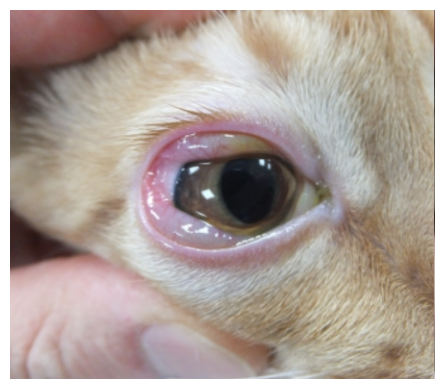

In [ ]:
# 그림 미리보기
from PIL import Image
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/종합설계/test_2.png'
image = Image.open(path)

# 이미지 표시
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()